# LPFP algorithm for optimal stopping MFGs with common noise and partial information: electricity markets (Results)

## By Roxana Dumitrescu, Marcos Leutscher and Peter Tankov

See https://arxiv.org/abs/2210.03554

*Results*

In this notebook we collect the results from the different settings and we compare them on plots.

We import the following packages

In [1]:
# Package imports

import numpy as np
import scipy
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import cm
import pandas as pd
import time
from scipy.stats import gamma, beta
from scipy.optimize import root_scalar
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from numpy.linalg import matrix_power

## I. Preliminaries

## 1) Time and common noise

The time horizon for the game is 18 years and the time step is 3 months. We define the time indices.

In [2]:
# Time space

T = 18.  # in years
Time_step = 3  # in months
N = int(T * (12 / Time_step))
Time = np.arange(N+1)  # Time indices
Time = np.reshape(Time, (Time.shape[0], 1))
dt = T/N
print('Time', Time.T)

Time [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
  48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
  72]]



The carbon price can jump up to the next state each 2 years and a half. We describe the space for the carbon price and the number of jumps.

In [3]:
# Noise space

time_jumps = 2.5 # There will be jumps each 2.5 years
n_jumps = 6      # 6 jumps
Noise = np.array([50, 75, 100, 125, 150, 175, 200])  # Carbon price state space
Noise = np.reshape(Noise, (Noise.shape[0], 1))
z_0 = Noise[0, 0]
print('Noise', Noise.T)

Noise [[ 50  75 100 125 150 175 200]]


In [4]:
# Jump time indices

J = [int(time_jumps*int(N/T)*(n+1)) for n in range(n_jumps)]
print('Jump times', J)

Jump times [10, 20, 30, 40, 50, 60]


We compute the collection of realizable sample paths of the common noise process. 

In [5]:
def paths(n):
    """
    Argument:
    n -- time
    
    Returns:
    Noise_paths -- list of all possible common noise paths up to time n
    """
    
    if n == 0:
        Noise_paths = [np.array([[0]])]
    else:
        Paths = paths(n - 1)
        Noise_paths = []
        for k in range(len(Paths)):
            z = Paths[k][-1, 0]
            if any(np.allclose(n, j) for j in J):
                Noise_paths.append(np.append(Paths[k], np.array([[z]]), axis = 0))
                Noise_paths.append(np.append(Paths[k], np.array([[z+1]]), axis = 0))
            else:
                Noise_paths.append(np.append(Paths[k], np.array([[z]]), axis = 0))
                    
    return Noise_paths

In [6]:
# Noise paths space

Noise_paths = paths(N)

n_c = len(Noise_paths)  # Total number of common noise paths

For example, we can select the third path and obtain its values at each time.

In [7]:
print(Noise[Noise_paths[3], 0].T)

[[ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
   50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
   50  50  50  50  50  50  50  50  50  50  50  50  50  50  75  75  75  75
   75  75  75  75  75  75 100 100 100 100 100 100 100 100 100 100 100 100
  100]]


We can visualize all the common noise paths as follows.

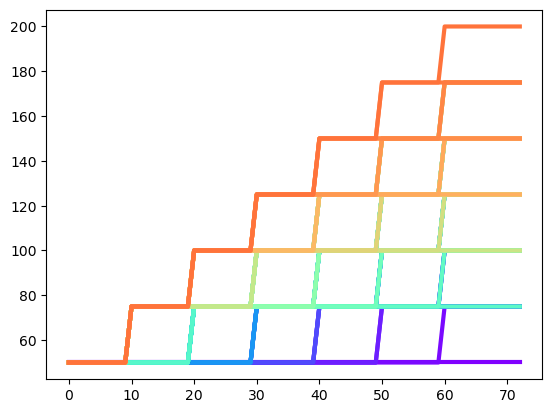

In [8]:
colors = iter(cm.rainbow(np.linspace(0, 0.85, n_c)))

for counter_noise in range(len(Noise_paths)):
    plt.plot(Time[:, 0], Noise[Noise_paths[counter_noise], 0], color = next(colors), linewidth = 3)
plt.show()

We define the map $U$ which associates to each path its history in matrix form, up to time $n$.

In [9]:
def U(n, omega):
    """
    Argument:
    n -- time
    omega -- common noise path
    
    Returns:
    U -- matrix of bits characterizing the path omega up to time n
    """
    U = np.zeros((Time.shape[0], Noise.shape[0]))
    for i in range(n+1):
        for k in range(Noise.shape[0]):
            U[i, k] = (omega[i, 0] == k)
    return U

For example:

In [10]:
print(U(60, Noise_paths[-1]))

[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.

We define the set of all possible values of $U_n$ denoted by $\Omega_n$ in the article.

In [11]:
def Omega_set(n):
    """
    Argument:
    n -- time
    
    Returns:
    Omega -- List with the elements of \Omega_n
    """
    Omega = []
    Proba = []
    
    Noise_paths = paths(n)
    for k in range(len(Noise_paths)):
        Omega.append(U(n, Noise_paths[k]))
    return Omega

We create a list containing the cardinal of $\Omega_n$ and a list containing the $u\in \Omega_n$.

In [12]:
len_Omega = []
Omega_list = []

for n in range(Time.shape[0]):
    Omega = Omega_set(n)
    len_Omega.append(len(Omega))
    Omega_list.append(Omega)

We define the functions $\psi_n$ verifying $\psi_k(U_n)=Z_k$, for $k\leq n$.

In [13]:
def psi(n, U):
    """
    Argument:
    n -- time
    U -- matrix of bits characterizing the path omega up to time n
    
    Returns:
    Associated value in $H$
    """
    row = U[n, :]
    z_index = np.nonzero(row)[0]
    if z_index.shape[0] > 0:
        return Noise[z_index[0], 0]
    else:
        return 0.

## 2) States

We describe the dynamics of the conventional and renewable producers.

In [14]:
# Conventional

C_min = 0.
C_max = 70.

t_beta = 0.429 # in tonCO2/MWh

theta = 37.94 * 0.88 - t_beta * z_0  #0.88 is the conversion of euros to GBP
stdC = 12.53 * 0.88
k = 0.5
delta = stdC * np.sqrt(2. * k / theta)

dC = delta * np.sqrt(theta * dt)
n_1 = int(np.ceil((C_max - C_min) / dC))

E_1 = np.linspace(C_min, C_max, num = n_1 + 1)
E_1 = np.reshape(E_1, (E_1.shape[0], 1))
dC = E_1[1, 0] - E_1[0, 0]

m0 = gamma.pdf(E_1, a = 2*theta*k/(delta**2), scale = delta**2/(2*k))
m0 = m0/np.sum(m0)

# Renewable

R_min = 0.3
R_max = 0.6

bartheta= 0.4261
stdR = 0.0443   
bark = 0.5
bardelta = stdR * np.sqrt(2. * bark / (bartheta * (1 - bartheta) - stdR**2))

dR = bardelta * np.sqrt(bartheta * (1 - bartheta) * dt)
n_2 = int(np.ceil((R_max - R_min) / dR))

E_2 = np.linspace(R_min, R_max, num = n_2 + 1)
E_2 = np.reshape(E_2, (E_2.shape[0], 1))
dR = E_2[1, 0] - E_2[0, 0]

barm0 = beta.pdf(E_2, a = 2*bark*bartheta/(bardelta**2), b = 2*bark*(1-bartheta)/(bardelta**2))
barm0 = barm0/np.sum(barm0)

The following functions define the transition kernel of the conventional producer.

In [15]:
# Dynamics conventional

def b(x):
    return k * (theta - x)

def sigma(x):
    return delta * x**(1/2)

def pi_B(x, X):
    if np.allclose(x, E_1[0, 0]):
        if np.allclose(X, E_1[1, 0]):
            P = 1.
        else:
            P = 0.
    elif np.allclose(x, E_1[-1, 0]):
        if np.allclose(X, E_1[-2, 0]):
            P = 1.
        else:
            P = 0.
    else:
        if np.allclose(X, x + dC): 
            P = (sigma(x)**2/2 + dC*np.maximum(b(x), 0))/(sigma(x)**2 + dC*np.abs(b(x)))
        elif np.allclose(X, x - dC): 
            P = (sigma(x)**2/2 - dC*np.minimum(b(x), 0))/(sigma(x)**2 + dC*np.abs(b(x)))
        else:
            P = 0.
    return P   

The following functions define the transition kernel of the renewable producer.

In [16]:
# Dynamics renewable

def bar_b(x):
    return bark*(bartheta-x)

def bar_sigma(x):
    return bardelta*(x*(1-x))**(1/2)

def pi_R(x, X):
    if np.allclose(x, E_2[0, 0]):
        if np.allclose(X, E_2[1, 0]):
            P = 1.
        else:
            P = 0.
    elif np.allclose(x, E_2[-1, 0]):
        if np.allclose(X, E_2[-2, 0]):
            P = 1.
        else:
            P = 0.
    else:
        if np.allclose(X, x + dR): 
            P = (bar_sigma(x)**2/2 + dR*np.maximum(bar_b(x), 0))/(bar_sigma(x)**2 + dR*np.abs(bar_b(x)))
        elif np.allclose(X, x - dR): 
            P = (bar_sigma(x)**2/2 - dR*np.minimum(bar_b(x), 0))/(bar_sigma(x)**2 + dR*np.abs(bar_b(x)))
        else:
            P = 0.
    return P   

## 3) Parameters of the reward functions


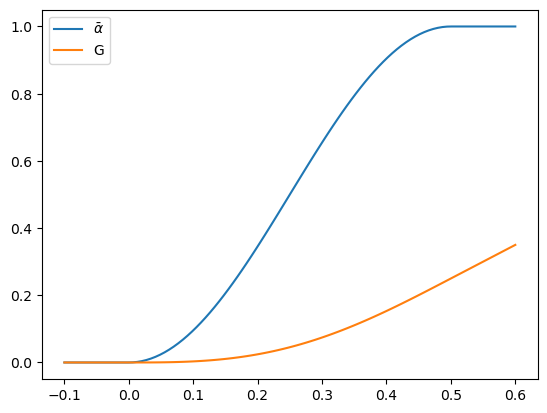

In [17]:
## Bidding function

c_max = 0.5

def bar_alpha(x):
    return (x > c_max) + 1/2*(1 + np.sin(-np.pi/2 + np.pi/c_max*x))*(0 <= x <= c_max)

bar_alpha = np.vectorize(bar_alpha)
x0 = np.linspace(-0.1, 0.6, 100)
plt.plot(x0, bar_alpha(x0), label=r"$\bar \alpha$")

## Gain function

def Gain(x):
    return (x-c_max/2)*(x > c_max) + 1/2*(x-c_max/np.pi*np.cos(-np.pi/2 + np.pi/c_max*x))*(0 <= x <= c_max)

Gain = np.vectorize(Gain)
plt.plot(x0, Gain(x0), label = "G")
plt.legend();

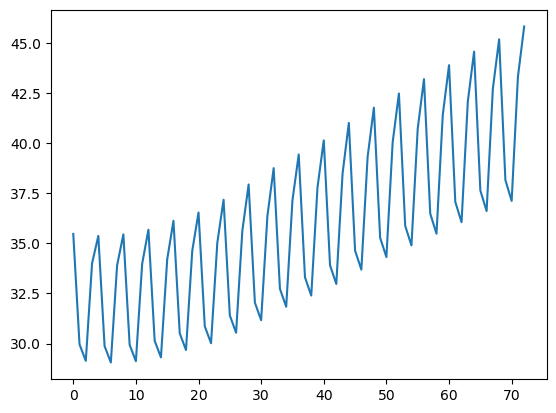

In [18]:
# Demand

beta_factor = 0.015

D = pd.read_excel("Demand_array.xlsx", decimal=',', header=None)
D = D.to_numpy()
D = D.reshape(-1)

sc = np.array([1.10352635, 0.93209028, 0.90656527, 1.05781809])
Lambda = np.tile(sc, int(T))
Lambda = np.append(Lambda, sc[0])

# Adjusting for seasonal cycle

d = np.zeros(73)
for i in range(int(T)): 
    d[i*4:(i+1)*4] = D[i]  
d[-1] = D[-1]

r_d = 1.2875630406414182 # peak / offpeak demand ratio
c_p = 65./168. # peak hours
c_o = 1. - c_p

bar_c_p = r_d/(c_p*r_d+c_o)
bar_c_o = 1/(c_p*r_d+c_o)

plt.plot(np.arange(d.shape[0]), Lambda*d);

In [19]:
# Capacities, cap price and baseline conventional supply

I_C = 35.9
I_R_b = 35.6
I_R = 47.

p_max = 150.

def S_b(x):
    return 12.1/p_max*x

In [20]:
# Costs and rates

rho = 0.086

kappa_C = 30.
K_C = 0.
gamma_C = np.log(2.)/30.

K_R = 1377.
kappa_R = 0.0125 * 1377.
gamma_R = np.log(2.)/10.

convcoef = 24.*365.25/1000. # GBP/MWh = convcoef GBP/kWyr

In [21]:
# Transition matrix of R to compute E[R_n]

Q = np.zeros((E_2.shape[0], E_2.shape[0]))

for i in range(E_2.shape[0]):
    for j in range(E_2.shape[0]):
        Q[i, j] = pi_R(E_2[i], E_2[j])

mean_R = []

for n in range(Time.shape[0]):
    Q_n = matrix_power(Q, n)
    mean_R_n = np.matmul(np.matmul(barm0.T, Q_n), E_2)
    mean_R.append(mean_R_n)

In [22]:
def S_c(m):
    def Supply_C(z, p):
        return I_C * np.sum(bar_alpha(p - E_1 - t_beta*z)*m) + S_b(p)
    return Supply_C

def S_r(n, bar_m):
    return (I_R_b + I_R) * mean_R[n] - I_R * np.sum(E_2 * bar_m)

In [23]:
def bar_P(n, z, d, m, bar_m):
    Supply_R = S_r(n, bar_m)
    Supply_C = S_c(m)
    if d - Supply_R <= 0:
        p_star = 0
    elif d - Supply_R - Supply_C(z, p_max) > 0:
        p_star = p_max
    else:
        def res_demand(p):
            return d - Supply_R - Supply_C(z, p)
        p_star = root_scalar(res_demand, bracket = [0, p_max], x0 = p_max/2).root
    return p_star

## IV. Plots for the paper

We load the results from the other notebooks.

In [24]:
L_C1 = np.load('results1/L_C.npy', allow_pickle = True)
L_R1 = np.load('results1/L_R.npy', allow_pickle = True)
L_E1 = np.load('results1/L_E.npy', allow_pickle = True)

L_C2 = np.load('results2/L_C.npy', allow_pickle = True)
L_R2 = np.load('results2/L_R.npy', allow_pickle = True)
L_E2 = np.load('results2/L_E.npy', allow_pickle = True)

L_C_min = np.load('results_det_min/L_C_det.npy', allow_pickle = True)
L_R_min = np.load('results_det_min/L_R_det.npy', allow_pickle = True)

L_C_max = np.load('results_det_max/L_C_det.npy', allow_pickle = True)
L_R_max = np.load('results_det_max/L_R_det.npy', allow_pickle = True)


Omega_proba_list1 = np.load('Omega_proba_list1.npy', allow_pickle = True)
Omega_proba_list2 = np.load('Omega_proba_list2.npy', allow_pickle = True)

We plot the convergence of the algorithm for the settings 1 and 2.

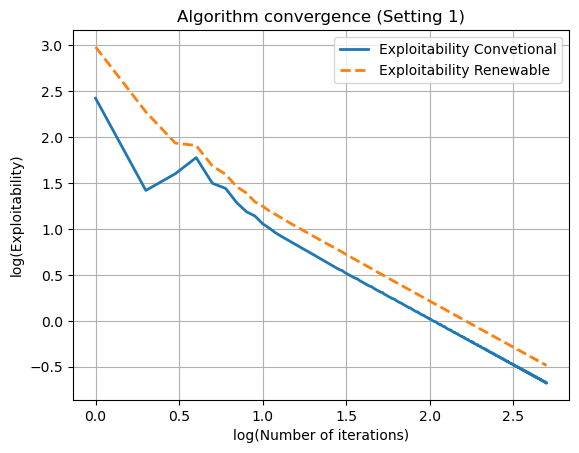

In [25]:
explo_C1, explo_R1, eps_array1 = L_E1

plt.plot(np.log10(np.arange(len(explo_C1)+1)[1:]), np.log10(explo_C1), label = r'Exploitability Convetional', linewidth = 2)
plt.plot(np.log10(np.arange(len(explo_R1)+1)[1:]), np.log10(explo_R1), label = r'Exploitability Renewable', linewidth = 2, linestyle ='dashed')
plt.grid()
plt.xlabel("log(Number of iterations)")
plt.ylabel("log(Exploitability)")
plt.title("Algorithm convergence (Setting 1)")
plt.legend();

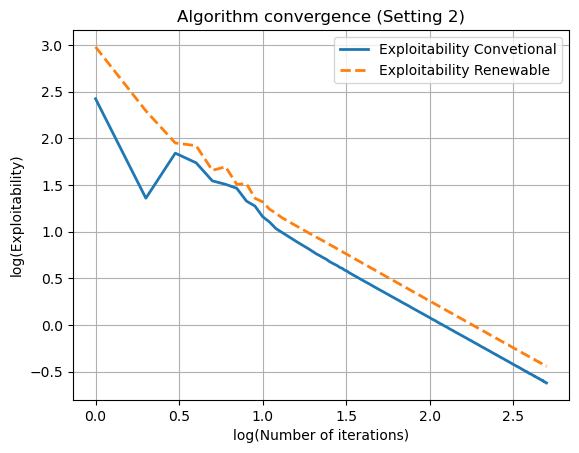

In [26]:
explo_C2, explo_R2, eps_array2 = L_E2

plt.plot(np.log10(np.arange(len(explo_C2)+1)[1:]), np.log10(explo_C2), label = r'Exploitability Convetional', linewidth = 2)
plt.plot(np.log10(np.arange(len(explo_R2)+1)[1:]), np.log10(explo_R2), label = r'Exploitability Renewable', linewidth = 2, linestyle ='dashed')
plt.grid()
plt.xlabel("log(Number of iterations)")
plt.ylabel("log(Exploitability)")
plt.title("Algorithm convergence (Setting 2)")
plt.legend();

We define the dates for the model.

In [27]:
T_y = 2022 + Time*dt
print(T_y.T)

[[2022.   2022.25 2022.5  2022.75 2023.   2023.25 2023.5  2023.75 2024.
  2024.25 2024.5  2024.75 2025.   2025.25 2025.5  2025.75 2026.   2026.25
  2026.5  2026.75 2027.   2027.25 2027.5  2027.75 2028.   2028.25 2028.5
  2028.75 2029.   2029.25 2029.5  2029.75 2030.   2030.25 2030.5  2030.75
  2031.   2031.25 2031.5  2031.75 2032.   2032.25 2032.5  2032.75 2033.
  2033.25 2033.5  2033.75 2034.   2034.25 2034.5  2034.75 2035.   2035.25
  2035.5  2035.75 2036.   2036.25 2036.5  2036.75 2037.   2037.25 2037.5
  2037.75 2038.   2038.25 2038.5  2038.75 2039.   2039.25 2039.5  2039.75
  2040.  ]]


We define the indices of the minimal and maximal carbon price trajectories.

In [28]:
w_min = Noise_paths[0]
w_max = Noise_paths[-1]

We store all the measures.

In [29]:
muC1, mC1, *_ = L_C1
muR1, mR1, *_ = L_R1
muC2, mC2, *_ = L_C2
muR2, mR2, *_ = L_R2
muC_min, mC_min, *_ = L_C_min
muR_min, mR_min, *_ = L_R_min
muC_max, mC_max, *_ = L_C_max
muR_max, mR_max, *_ = L_R_max

We compute the mean measure $m$ for the two producers in each setting.

In [30]:
mC1_mean = np.zeros((Time.shape[0]-1, E_1.shape[0]))
for n in range(Time.shape[0]-1):
    M_n = np.concatenate(mC1[n], axis = 1)
    mC1_mean[n, :] = np.average(M_n, axis = 1, weights = np.concatenate(Omega_proba_list1[n]))

mR1_mean = np.zeros((Time.shape[0]-1, E_2.shape[0]))
for n in range(Time.shape[0]-1):
    M_n = np.concatenate(mR1[n], axis = 1)
    mR1_mean[n, :] = np.average(M_n, axis = 1, weights = np.concatenate(Omega_proba_list1[n]))
    
    
mC2_mean = np.zeros((Time.shape[0]-1, E_1.shape[0]))
for n in range(Time.shape[0]-1):
    M_n = np.concatenate(mC2[n], axis = 1)
    mC2_mean[n, :] = np.average(M_n, axis = 1, weights = np.concatenate(Omega_proba_list2[n]))

mR2_mean = np.zeros((Time.shape[0]-1, E_2.shape[0]))
for n in range(Time.shape[0]-1):
    M_n = np.concatenate(mR2[n], axis = 1)
    mR2_mean[n, :] = np.average(M_n, axis = 1, weights = np.concatenate(Omega_proba_list2[n]))

The following functions allow to extract the measure flow $m$ for each carbon price trajectory.

In [31]:
def U_index(omega):
    u = U(N, omega)
    Indices = []
    for n in range(Time.shape[0]):
        i = 0
        while i < len_Omega[n]: 
            if np.allclose(u[:(n+1), :], Omega_list[n][i][:(n+1), :]):
                Indices.append(i)
                i = len_Omega[n]
            else:
                i += 1
    return Indices

def m_C_omega(m, omega):
    M = np.zeros((Time.shape[0]-1, E_1.shape[0]))
    Indices = U_index(omega)
    for n in range(Time.shape[0]-1):
        M[n, :] = m[n][Indices[n]][:, 0]
    return M

def m_R_omega(m, omega):
    M = np.zeros((Time.shape[0]-1, E_2.shape[0]))
    Indices = U_index(omega)
    for n in range(Time.shape[0]-1):
        M[n, :] = m[n][Indices[n]][:, 0]
    return M

We plot the installed capacity of both producers in both settings under the minimal and maximal trajectories and compare them to the same trajectories in the deterministic MFG. We also plot the expectations over the carbon price distribution for both settings.

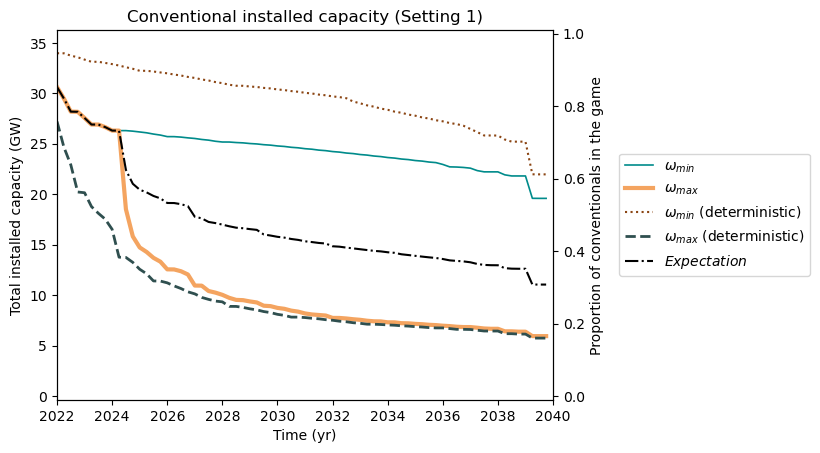

In [32]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

mC1_min = m_C_omega(mC1, w_min)
mC1_min_mass = np.sum(mC1_min, axis=1)
ax1.plot(T_y[:-1, 0], mC1_min_mass*I_C, label = r"$\omega_{min}$", linewidth = 1.2, color='darkcyan')

mC1_max = m_C_omega(mC1, w_max)
mC1_max_mass = np.sum(mC1_max, axis=1)
ax1.plot(T_y[:-1, 0], mC1_max_mass*I_C, label = r"$\omega_{max}$", linewidth = 3., color='sandybrown')

mC_min_mass = np.sum(mC_min, axis = 1)
ax1.plot(T_y[:-1, 0], mC_min_mass*I_C, label = r"$\omega_{min}$ (deterministic)", linewidth = 1.5, linestyle ='dotted', color='saddlebrown')

mC_max_mass = np.sum(mC_max, axis = 1)
ax1.plot(T_y[:-1, 0], mC_max_mass*I_C, label = r"$\omega_{max}$ (deterministic)", linewidth = 2., linestyle ='dashed', color='darkslategrey')

mC1_mean_mass = np.sum(mC1_mean, axis = 1)
ax1.plot(T_y[:-1, 0], mC1_mean_mass*I_C, label = r"$Expectation$", color='black', linestyle ='dashdot')

ax1.set_xlabel("Time (yr)")
ax1.set_title("Conventional installed capacity (Setting 1)")
ax1.set_xlim(2022, 2040)
ax1.set_ylim(-0.01*I_C, 1.01*I_C)
ax1.set_ylabel("Total installed capacity (GW)")
ax2.set_ylim(-0.01, 1.01)
ax2.set_ylabel("Proportion of conventionals in the game")
ax1.legend(loc='center left', bbox_to_anchor=(1.12, 0.5));

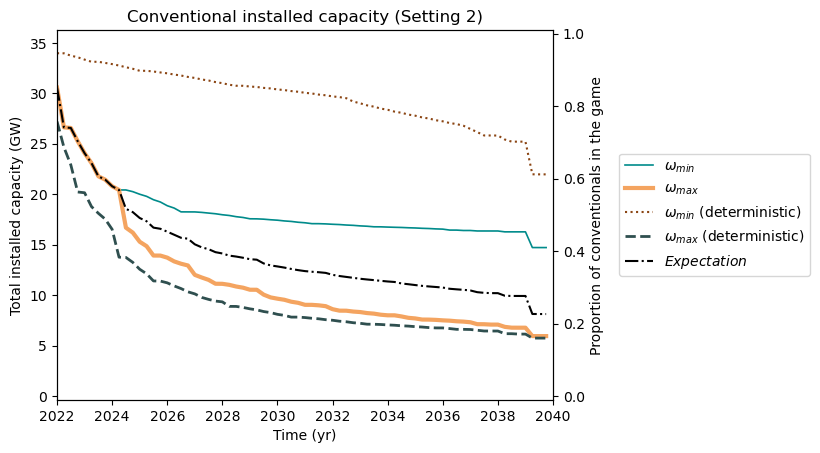

In [33]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

mC2_min = m_C_omega(mC2, w_min)
mC2_min_mass = np.sum(mC2_min, axis=1)
ax1.plot(T_y[:-1, 0], mC2_min_mass*I_C, label = r"$\omega_{min}$", linewidth = 1.2, color='darkcyan')

mC2_max = m_C_omega(mC2, w_max)
mC2_max_mass = np.sum(mC2_max, axis=1)
ax1.plot(T_y[:-1, 0], mC2_max_mass*I_C, label = r"$\omega_{max}$", linewidth = 3., color='sandybrown')

mC_min_mass = np.sum(mC_min, axis = 1)
ax1.plot(T_y[:-1, 0], mC_min_mass*I_C, label = r"$\omega_{min}$ (deterministic)", linewidth = 1.5, linestyle ='dotted', color='saddlebrown')

mC_max_mass = np.sum(mC_max, axis = 1)
ax1.plot(T_y[:-1, 0], mC_max_mass*I_C, label = r"$\omega_{max}$ (deterministic)", linewidth = 2., linestyle ='dashed', color='darkslategrey')

mC2_mean_mass = np.sum(mC2_mean, axis = 1)
ax1.plot(T_y[:-1, 0], mC2_mean_mass*I_C, label = r"$Expectation$", color='black', linestyle ='dashdot')

ax1.set_xlabel("Time (yr)")
ax1.set_title("Conventional installed capacity (Setting 2)")
ax1.set_xlim(2022, 2040)
ax1.set_ylim(-0.01*I_C, 1.01*I_C)
ax1.set_ylabel("Total installed capacity (GW)")
ax2.set_ylim(-0.01, 1.01)
ax2.set_ylabel("Proportion of conventionals in the game")
ax1.legend(loc='center left', bbox_to_anchor=(1.12, 0.5));

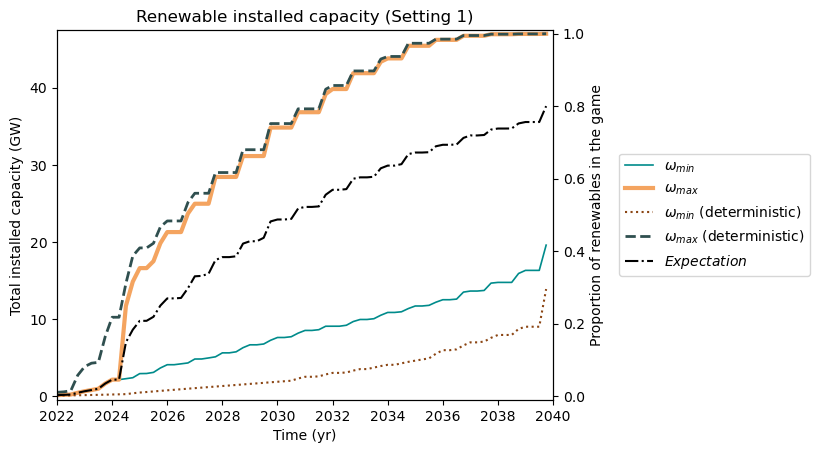

In [34]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

mR1_min = m_R_omega(mR1, w_min)
mR1_min_mass = np.sum(mR1_min, axis=1)
ax1.plot(T_y[:-1, 0], (1-mR1_min_mass)*I_R, label = r"$\omega_{min}$", linewidth = 1.2, color='darkcyan')

mR1_max = m_R_omega(mR1, w_max)
mR1_max_mean = np.sum(mR1_max, axis=1)
ax1.plot(T_y[:-1, 0], (1-mR1_max_mean)*I_R, label = r"$\omega_{max}$", linewidth = 3., color='sandybrown')

mR_min_mass = np.sum(mR_min, axis=1)
ax1.plot(T_y[:-1, 0], (1-mR_min_mass)*I_R, label = r"$\omega_{min}$ (deterministic)", linewidth = 1.5, linestyle ='dotted', color='saddlebrown')

mR_max_mass = np.sum(mR_max, axis=1)
ax1.plot(T_y[:-1, 0], (1-mR_max_mass)*I_R, label = r"$\omega_{max}$ (deterministic)", linewidth = 2., linestyle ='dashed', color='darkslategrey')

mR1_mean_mass = np.sum(mR1_mean, axis=1)
ax1.plot(T_y[:-1, 0], (1-mR1_mean_mass)*I_R, label = r"$Expectation$", color='black', linestyle ='dashdot')

ax1.set_xlabel("Time (yr)")
ax1.set_title("Renewable installed capacity (Setting 1)")
ax1.set_xlim(2022, 2040)
ax1.set_ylim(-0.01*I_R, 1.01*I_R)
ax1.set_ylabel("Total installed capacity (GW)")
ax2.set_ylim(-0.01, 1.01)
ax2.set_ylabel("Proportion of renewables in the game")
ax1.legend(loc='center left', bbox_to_anchor=(1.12, 0.5));

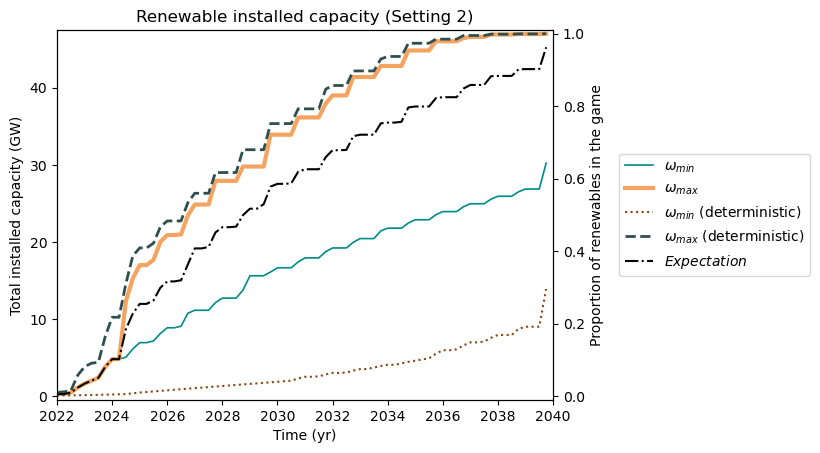

In [35]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

mR2_min = m_R_omega(mR2, w_min)
mR2_min_mass = np.sum(mR2_min, axis=1)
ax1.plot(T_y[:-1, 0], (1-mR2_min_mass)*I_R, label = r"$\omega_{min}$", linewidth = 1.2, color='darkcyan')

mR2_max = m_R_omega(mR2, w_max)
mR2_max_mean = np.sum(mR2_max, axis=1)
ax1.plot(T_y[:-1, 0], (1-mR2_max_mean)*I_R, label = r"$\omega_{max}$", linewidth = 3., color='sandybrown')

mR_min_mass = np.sum(mR_min, axis=1)
ax1.plot(T_y[:-1, 0], (1-mR_min_mass)*I_R, label = r"$\omega_{min}$ (deterministic)", linewidth = 1.5, linestyle ='dotted', color='saddlebrown')

mR_max_mass = np.sum(mR_max, axis=1)
ax1.plot(T_y[:-1, 0], (1-mR_max_mass)*I_R, label = r"$\omega_{max}$ (deterministic)", linewidth = 2., linestyle ='dashed', color='darkslategrey')

mR2_mean_mass = np.sum(mR2_mean, axis=1)
ax1.plot(T_y[:-1, 0], (1-mR2_mean_mass)*I_R, label = r"$Expectation$", color='black', linestyle ='dashdot')

ax1.set_xlabel("Time (yr)")
ax1.set_title("Renewable installed capacity (Setting 2)")
ax1.set_xlim(2022, 2040)
ax1.set_ylim(-0.01*I_R, 1.01*I_R)
ax1.set_ylabel("Total installed capacity (GW)")
ax2.set_ylim(-0.01, 1.01)
ax2.set_ylabel("Proportion of renewables in the game")
ax1.legend(loc='center left', bbox_to_anchor=(1.12, 0.5));

We compute the prices for both settings under the min and max trajectories of the carbon price as well as the prices in the deterministic MFGs for the same trajectories.

In [36]:
Z_min = Noise[w_min, :]
Z_max = Noise[w_max, :]

# Prices Setting 1 (under min and max trajectories)

p_price1_min = []
op_price1_min = []
for n in range(Time.shape[0]-1):
    p_price1_min.append(bar_P(n, Z_min[n, :], 
                              Lambda[n]*bar_c_p*(d[n] + beta_factor * (Z_min[n, :]-z_0)), mC1_min[[n], :].T, mR1_min[[n], :].T))
    op_price1_min.append(bar_P(n, Z_min[n, :], 
                               Lambda[n]*bar_c_o*(d[n] + beta_factor * (Z_min[n, :]-z_0)),mC1_min[[n], :].T, mR1_min[[n], :].T))

p_price1_max = []
op_price1_max = []
for n in range(Time.shape[0]-1):
    p_price1_max.append(bar_P(n, Z_max[n, :], 
                              Lambda[n]*bar_c_p*(d[n] + beta_factor * (Z_max[n, :]-z_0)), mC1_max[[n], :].T, mR1_max[[n], :].T))
    op_price1_max.append(bar_P(n, Z_max[n, :], 
                               Lambda[n]*bar_c_o*(d[n] + beta_factor * (Z_max[n, :]-z_0)), mC1_max[[n], :].T, mR1_max[[n], :].T))
    
# Prices Setting 2 (under min and max trajectories)

p_price2_min = []
op_price2_min = []
for n in range(Time.shape[0]-1):
    p_price2_min.append(bar_P(n, Z_min[n, :], 
                              Lambda[n]*bar_c_p*(d[n] + beta_factor * (Z_min[n, :]-z_0)), mC2_min[[n], :].T, mR2_min[[n], :].T))
    op_price2_min.append(bar_P(n, Z_min[n, :], 
                               Lambda[n]*bar_c_o*(d[n] + beta_factor * (Z_min[n, :]-z_0)), mC2_min[[n], :].T, mR2_min[[n], :].T))

p_price2_max = []
op_price2_max = []
for n in range(Time.shape[0]-1):
    p_price2_max.append(bar_P(n, Z_max[n, :], 
                              Lambda[n]*bar_c_p*(d[n] + beta_factor * (Z_max[n, :]-z_0)), mC2_max[[n], :].T, mR2_max[[n], :].T))
    op_price2_max.append(bar_P(n, Z_max[n, :], 
                               Lambda[n]*bar_c_o*(d[n] + beta_factor * (Z_max[n, :]-z_0)), mC2_max[[n], :].T, mR2_max[[n], :].T))

# Prices min deterministic

p_price_min = []
op_price_min = []

for n in range(Time.shape[0]-1):
    p_price_min.append(bar_P(n, Z_min[n, :], 
                             Lambda[n]*bar_c_p*(d[n] + beta_factor * (Z_min[n, :]-z_0)), mC_min[[n], :].T, mR_min[[n], :].T))
    op_price_min.append(bar_P(n, Z_min[n, :], 
                              Lambda[n]*bar_c_o*(d[n] + beta_factor * (Z_min[n, :]-z_0)), mC_min[[n], :].T, mR_min[[n], :].T))

# Prices max deterministic    
    
p_price_max = []
op_price_max = []

for n in range(Time.shape[0]-1):
    p_price_max.append(bar_P(n, Z_max[n, :], 
                             Lambda[n]*bar_c_p*(d[n] + beta_factor * (Z_max[n, :]-z_0)), mC_max[[n], :].T, mR_max[[n], :].T))
    op_price_max.append(bar_P(n, Z_max[n, :], 
                              Lambda[n]*bar_c_o*(d[n] + beta_factor * (Z_max[n, :]-z_0)), mC_max[[n], :].T, mR_max[[n], :].T))


We compute the average (with respect to the carbon price distribution) prices for both settings.

In [37]:
# Setting 1

p_price1_mean = []
op_price1_mean = []
for k in range(n_c):
    Z_k = Noise[Noise_paths[k], :]
    p_price_k = []
    op_price_k = []
    mC1_k = m_C_omega(mC1, Noise_paths[k])
    mR1_k = m_R_omega(mR1, Noise_paths[k])

    for n in range(Time.shape[0]-1):
        p_price_k.append(bar_P(n, Z_k[n, :], 
                                   Lambda[n]*bar_c_p*(d[n] + beta_factor * (Z_k[n, :]-z_0)), mC1_k[[n], :].T, mR1_k[[n], :].T))
        op_price_k.append(bar_P(n, Z_k[n, :], 
                              Lambda[n]*bar_c_o*(d[n] + beta_factor * (Z_k[n, :]-z_0)), mC1_k[[n], :].T, mR1_k[[n], :].T))
    p_price1_mean.append(p_price_k)
    op_price1_mean.append(op_price_k)
p_price1_mean = np.array(p_price1_mean)
op_price1_mean = np.array(op_price1_mean)
p_price1_mean = np.average(p_price1_mean, weights = np.array(Omega_proba_list1[-1]).reshape(-1), axis = 0)
op_price1_mean = np.average(op_price1_mean, weights = np.array(Omega_proba_list1[-1]).reshape(-1), axis = 0)



# Setting 2

p_price2_mean = []
op_price2_mean = []
for k in range(n_c):
    Z_k = Noise[Noise_paths[k], :]
    p_price_k = []
    op_price_k = []
    mC2_k = m_C_omega(mC2, Noise_paths[k])
    mR2_k = m_R_omega(mR2, Noise_paths[k])

    for n in range(Time.shape[0]-1):
        p_price_k.append(bar_P(n, Z_k[n, :], 
                                   Lambda[n]*bar_c_p*(d[n] + beta_factor * (Z_k[n, :]-z_0)), mC2_k[[n], :].T, mR2_k[[n], :].T))
        op_price_k.append(bar_P(n, Z_k[n, :], 
                              Lambda[n]*bar_c_o*(d[n] + beta_factor * (Z_k[n, :]-z_0)), mC2_k[[n], :].T, mR2_k[[n], :].T))
    p_price2_mean.append(p_price_k)
    op_price2_mean.append(op_price_k)
p_price2_mean = np.array(p_price2_mean)
op_price2_mean = np.array(op_price2_mean)
p_price2_mean = np.average(p_price2_mean, weights = np.array(Omega_proba_list2[-1]).reshape(-1), axis = 0)
op_price2_mean = np.average(op_price2_mean, weights = np.array(Omega_proba_list2[-1]).reshape(-1), axis = 0)

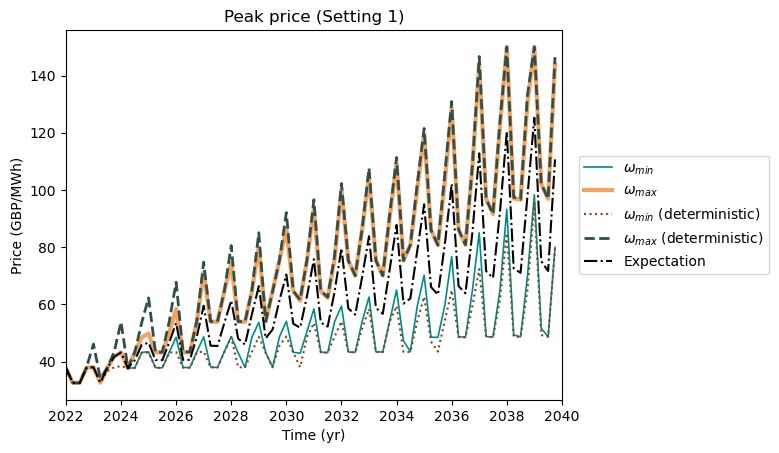

In [38]:
plt.plot(T_y[:-1, 0], p_price1_min, label = r"$\omega_{min}$", linewidth = 1.2, color='darkcyan')
plt.plot(T_y[:-1, 0], p_price1_max, label = r"$\omega_{max}$", linewidth = 3., color='sandybrown')
plt.plot(T_y[:-1, 0], p_price_min, label = r"$\omega_{min}$ (deterministic)", linewidth = 1.5, linestyle ='dotted', color='saddlebrown')
plt.plot(T_y[:-1, 0], p_price_max, label = r"$\omega_{max}$ (deterministic)", linewidth = 2., linestyle ='dashed', color='darkslategrey')
plt.plot(T_y[:-1, 0], p_price1_mean, label = r"Expectation", color='black', linestyle ='dashdot')
plt.xlabel("Time (yr)")
plt.ylabel("Price (GBP/MWh)")
plt.title("Peak price (Setting 1)")
plt.xlim(2022, 2040)
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5));

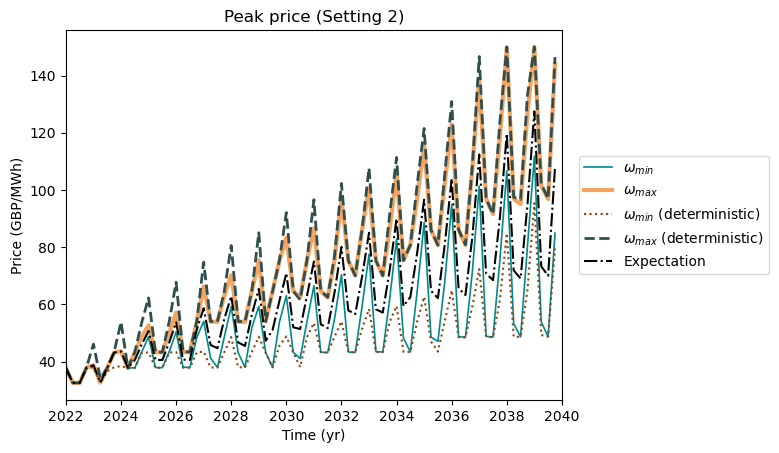

In [39]:
plt.plot(T_y[:-1, 0], p_price2_min, label = r"$\omega_{min}$", linewidth = 1.2, color='darkcyan')
plt.plot(T_y[:-1, 0], p_price2_max, label = r"$\omega_{max}$", linewidth = 3., color='sandybrown')
plt.plot(T_y[:-1, 0], p_price_min, label = r"$\omega_{min}$ (deterministic)", linewidth = 1.5, linestyle ='dotted', color='saddlebrown')
plt.plot(T_y[:-1, 0], p_price_max, label = r"$\omega_{max}$ (deterministic)", linewidth = 2., linestyle ='dashed', color='darkslategrey')
plt.plot(T_y[:-1, 0], p_price2_mean, label = r"Expectation", color='black', linestyle ='dashdot')
plt.xlabel("Time (yr)")
plt.ylabel("Price (GBP/MWh)")
plt.title("Peak price (Setting 2)")
plt.xlim(2022, 2040)
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5));

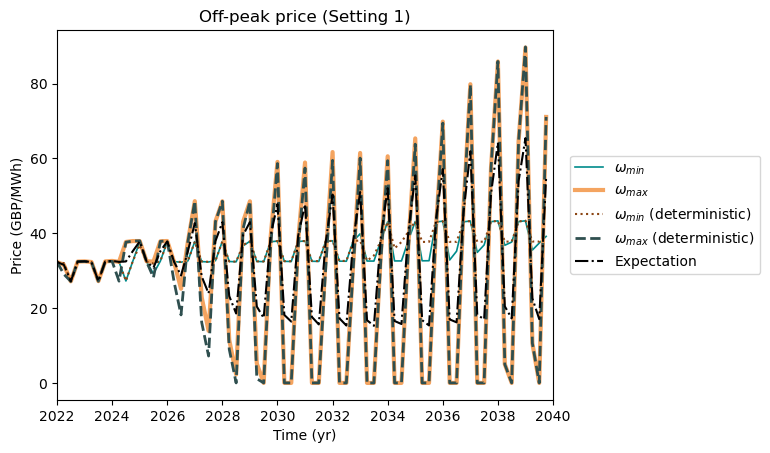

In [40]:
plt.plot(T_y[:-1, 0], op_price1_min, label = r"$\omega_{min}$", linewidth = 1.2, color='darkcyan')
plt.plot(T_y[:-1, 0], op_price1_max, label = r"$\omega_{max}$", linewidth = 3., color='sandybrown')
plt.plot(T_y[:-1, 0], op_price_min, label = r"$\omega_{min}$ (deterministic)", linewidth = 1.5, linestyle ='dotted', color='saddlebrown')
plt.plot(T_y[:-1, 0], op_price_max, label = r"$\omega_{max}$ (deterministic)", linewidth = 2., linestyle ='dashed', color='darkslategrey')
plt.plot(T_y[:-1, 0], op_price1_mean, label = r"Expectation", color='black', linestyle ='dashdot')
plt.xlabel("Time (yr)")
plt.ylabel("Price (GBP/MWh)")
plt.title("Off-peak price (Setting 1)")
plt.xlim(2022, 2040)
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5));

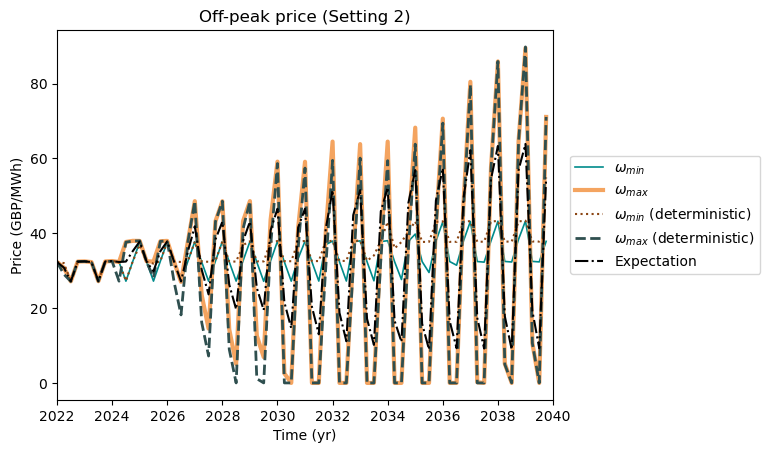

In [41]:
plt.plot(T_y[:-1, 0], op_price2_min, label = r"$\omega_{min}$", linewidth = 1.2, color='darkcyan')
plt.plot(T_y[:-1, 0], op_price2_max, label = r"$\omega_{max}$", linewidth = 3., color='sandybrown')
plt.plot(T_y[:-1, 0], op_price_min, label = r"$\omega_{min}$ (deterministic)", linewidth = 1.5, linestyle ='dotted', color='saddlebrown')
plt.plot(T_y[:-1, 0], op_price_max, label = r"$\omega_{max}$ (deterministic)", linewidth = 2., linestyle ='dashed', color='darkslategrey')
plt.plot(T_y[:-1, 0], op_price2_mean, label = r"Expectation", color='black', linestyle ='dashdot')
plt.xlabel("Time (yr)")
plt.ylabel("Price (GBP/MWh)")
plt.title("Off-peak price (Setting 2)")
plt.xlim(2022, 2040)
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5));